Topics in Python performance
================

When to optimize
-------------------

> We should forget about small efficiencies, say about 97% of the time: **premature optimization is the root of all evil**. Yet we should not pass up our opportunities in that critical 3% -- Donald Knuth

Step one in optimizing is deciding whether it is actually necessary.  The point that Knuth raises is that people spend a lot of time thinking of and developing optimizations for code that may in fact not matter.  The question "does it matter?" is actually quite complex.  Consider:

* **How long does the code take overall?** -- if a single run takes 1ms, why bother?
* **How many times does it get executed?** -- if that 1ms code is run $10^7$ times (3 days), now we're talking
* **How hard would it be to maintain your optimization?** -- if it slows down forward progress too much, you should reconsider
* **How much improvement can you get?** -- if you can only get 10% improvement, then almost certainly not worth the 7 hr gained
* **How long would it take you to fix?** -- if it takes you longer than 3 days, then you could have just run the code

While questions 1, 2 and 3 can be quite tricky, they are also hard to talk about in general.  Experience will gradually let you know if their answers lead you to optimize. For this notebook, I'll be sticking to questions 4 and 5 since they have more straightforward answers.

How to optimize
-----------------

1. **Algorithms** -- choosing how to solve a problem is usually the most important choice you can make
2. **Implementation** -- how you end up writing the actual code for the particular algorithm
3. **Hardware** -- understanding how that code is run on your particular hardware matters

Unfortunately, it is easy to get burned by simple things like `for` loops in Python (factors of 10,000x), so I will be starting with the implementation section here to make the other discussions more natural.

I. Implementation optimization
===============

To begin implementation optimizations, often, there is only a section of a program that needs to be addressed, usually the inner loop that is computationally intensive.  It is important to remove your prejudices of what is slowest though.  To study which parts of your program are slow and how much you can gain, *profile*.

### Profiling

Python includes many different options for finding the speed of different code sections. These include, but are not limited to:

* %timeit -- quick way to look at the speed of a single function call
* %prun -- distribution of time broken down by function (aggregates are useful)
* %lprun -- line profiling, listing time and number of calls for each line

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as pl
import scipy.ndimage as nd
import time

%matplotlib inline
%load_ext line_profiler

In [2]:
def create_noisy_sin(N=1000):
    x = np.linspace(0, 12*np.pi, N)
    y = np.sin(x) 
    d = y + (2*np.random.rand(*x.shape)-1)
    return x, d

x, y = create_noisy_sin(1000)

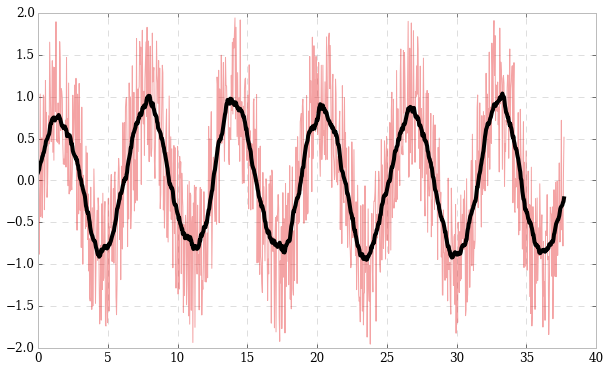

In [3]:
def boxcar1(a, size):
    length = a.shape[0]
    out = np.zeros_like(a)

    # for each element in the list
    for i in xrange(length):
        
        # add the `size' adjacent elements before and after this element
        for j in xrange(max(0,i-size/2), min(length,i+size/2)):
            out[i] += a[j]

    return out/size

x, y = create_noisy_sin(1000)
fig = pl.figure(figsize=(10,6))
pl.plot(x, y, lw=1, alpha=0.4)
pl.plot(x, boxcar1(y,40), lw=4, c='k')
pl.ylim(-2,2);

In [4]:
x, y = create_noisy_sin(10000)
%timeit boxcar1(y, 100)

1 loops, best of 3: 279 ms per loop


## Order of magnitude

450 ms is not bad, the plot refresh time in ipython.  But is it fast enough? Let's estimate how long this function should really take.  For an array of length $10^4$ and a filter of size $10^2$, we have approximately $10^6$ multiply-adds (for each $10^4$ we have to visit $10^2$ other elements and add them together).  An i7 procressor at 3GHz can do ~ 20 GFlops per core -- the code should run in:

50 microseconds!

What did we do wrong?

In [5]:
%prun boxcar1(y, 100)

```
   20007 function calls in 0.492 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.489    0.489    0.492    0.492 <ipython-input-92-e4d9e51769fc>:1(boxcar1)
    10000    0.002    0.000    0.002    0.000 {max}
    10000    0.001    0.000    0.001    0.000 {min}
        1    0.000    0.000    0.000    0.000 {numpy.core.multiarray.copyto}
        1    0.000    0.000    0.000    0.000 numeric.py:81(zeros_like)
        1    0.000    0.000    0.000    0.000 {numpy.core.multiarray.empty_like}
        1    0.000    0.000    0.000    0.000 {numpy.core.multiarray.zeros}
        1    0.000    0.000    0.492    0.492 <string>:1(<module>)
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}
```

In [6]:
%lprun -f boxcar1 boxcar1(y, 100)

```
Timer unit: 1e-06 s

Total time: 1.4166 s
File: <ipython-input-92-e4d9e51769fc>
Function: boxcar1 at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
==============================================================
     1                                           def boxcar1(a, size):
     2         1            5      5.0      0.0      length = a.shape[0]
     3         1           80     80.0      0.0      out = np.zeros_like(a)
     4                                           
     5                                               # for each element in the list
     6     10001         3392      0.3      0.2      for i in xrange(length):
     7                                                   
     9   1017450       411001      0.4     29.0          for j in xrange(max(0,i-size/2), min(length,i+size/2+1)):
    10   1007450      1002117      1.0     70.7              out[i] += a[j]/size
    11                                           
    12         1            1      1.0      0.0      return out
```

## Converting to numpy

So much time is spent on xrange in the inner loop and each addition with Python overhead comes to about 1 microsecond.  Typical additions in C are one clock cycle so we can improve by at least 1000x. Let's switch to numpy:

In [7]:
def boxcar2(a, size):
    length = len(a)
    out = np.zeros_like(a)
    tmp = np.pad(a, size/2, mode='constant', constant_values=0)
    for i in xrange(size):
        out += tmp[i:i+length]
    return out/size

In [8]:
%timeit boxcar2(y, 100)

1000 loops, best of 3: 568 µs per loop


In [9]:
%lprun -f boxcar2 boxcar2(y, 100)

```
Timer unit: 1e-06 s

Total time: 0.133911 s
File: <ipython-input-101-22e34ce97867>
Function: boxcar2 at line 3

Line #      Hits         Time  Per Hit   % Time  Line Contents
==============================================================
     3                                           def boxcar2(a, size):
     4         1         1148   1148.0      0.9      out = np.zeros_like(a)
     5       101          309      3.1      0.2      for i in xrange(size):
     6       100       130582   1305.8     97.5          out[i:-(size-i)] += a[size/2:-size/2]
     7         1         1872   1872.0      1.4      return out/size
```

## C/C++ solutions

In Python, we often have to turn to external libraries such as numpy to achieve the ultimate speed.  If the solution if already written for us, we can blame someone else for bugs and for the algorithm.

In [10]:
def boxcar3(a, size):
    return nd.filters.uniform_filter1d(a, size, mode='constant', cval=0)

%timeit boxcar1(y, 100)
%timeit boxcar2(y, 100)
%timeit boxcar3(y, 100)

1 loops, best of 3: 280 ms per loop
1000 loops, best of 3: 561 µs per loop
10000 loops, best of 3: 60.3 µs per loop


In [11]:
print np.allclose(boxcar1(y,100), boxcar2(y,100))
print np.allclose(boxcar1(y,100), boxcar3(y,100))

True
True


# Python libraries

* **numpy** -- linear algebra, special functions, numeric utilities
* **scipy** -- extending numpy for more specialized cases; also includes weave
* **numexpr** -- improve caching, simple numpy expressions (multi-core)
* **numba** -- contains JIT compiler for numpy
* **pyfftw** -- fastest fourier transform in the west

# Different Pythons

* **Cython** -- compiles Python into C and that C into a Python module (declare all types)
* **pypy** -- JIT compiler (doesn't work well with numpy / scipy)
* **swig** -- wrap large code bases (C/C++/etc) into Python modules

## Consider the function $\frac12 a^4 + a^8 + \sin{\frac1a}$

**numexpr** optimizes *simple* numpy expressions, caching values and allowing for parallelism through OpenMP

In [12]:
import numexpr as ne
a = np.random.rand(1000000)

%timeit 0.5*a**4 + a**8 + np.sin(1.0/a)
%timeit ne.evaluate('0.5*a**4 + a**8 + sin(1.0/a)')

10 loops, best of 3: 157 ms per loop
100 loops, best of 3: 7.82 ms per loop


**numba.jit** allows you to write naive looping code which gets compiled through LLVM and run as a plain Python function.  Very readable and few dependencies (anaconda)

In [13]:
import math
from numba import jit

@jit(nopython=True)
def weird_func(a, b, N):
    for i in xrange(N):
        t2 = a[i]*a[i]
        t4 = t2*t2
        t8 = t4*t4
        b[i] = 0.4*t4 + t8 + math.sin(1.0/a[i])
    return b

a = np.random.rand(1000000)
b = np.zeros_like(a)

%timeit weird_func(a,b,len(a))

The slowest run took 4.02 times longer than the fastest. This could mean that an intermediate result is being cached 
10 loops, best of 3: 28 ms per loop


**scipy.weave** allows you to directly write C code.  You can use other C files for any library as well giving more flexibility, but harder to maintain (usually)

In [14]:
from scipy import weave

code = """
for (int i=0; i<N; i++){
    double t2 = a[i]*a[i];
    double t4 = t2*t2;
    double t8 = t4*t4;
    
    b[i] = 0.5*t4 + t8 + sin(1.0/a[i]);
}
"""

a = np.random.rand(1000000)
b = np.zeros_like(a)
N = len(a)
%timeit weave.inline(code, ['a','b','N'])

10 loops, best of 3: 28.4 ms per loop


**cython** also compiles Python-like code into C extensions that are loaded as Python objects.  Need to be aware of typing and introduces new dependencies

In [15]:
%load_ext cython

In [16]:
%%cython

import numpy as np
cimport numpy as np
from libc.math cimport sin

cpdef weird_func_cython(np.ndarray[np.float64_t, ndim=1] a):
    cdef int N = a.shape[0]
    cdef np.float64_t t1, t2, t4, t8
    cdef int i
    
    cdef np.ndarray out = np.zeros(N, dtype=np.float64)
    
    for i in range(N):
        t1 = a[i]
        t2 = t1*t1
        t4 = t2*t2
        t8 = t4*t4
        out[i] = 0.5*t4 + t8 + sin(1.0/t1)

    return out

/media/scratch/anaconda/lib/python2.7/site-packages/IPython/utils/path.py:264: UserWarning: get_ipython_cache_dir has moved to the IPython.paths module
  warn("get_ipython_cache_dir has moved to the IPython.paths module")


In [17]:
%timeit weird_func_cython(a)

10 loops, best of 3: 60.3 ms per loop


### Some libraries are surprising, consider ffts:

In [18]:
import pyfftw
from pyfftw.builders import fft2

a = np.random.rand(512,512)
pfft2 = fft2(a, overwrite_input=False, planner_effort='FFTW_MEASURE', threads=4)

%timeit np.fft.fft2(a)
%timeit pfft2.execute()

100 loops, best of 3: 9.81 ms per loop
100 loops, best of 3: 2.42 ms per loop


II. Algorithmic optimization
==============

So far we have been missing the biggest piece of optimization: *algorithms*.  Given a method for solving a problem, those previous tricks help a lot.  However, changing your outlook on what the problem is can be much more important.

* Use your maths (symbolic differentiation, do your algebra / integrals)
* Tradeoff time for memory usage
* Are you asking the right question?
* Use the correct data structures

Examples of algorithmic changes including using FFTs to do convolutions, using dictionaries to keep track of visited entries, or switching to probabilistic member testing using bloom filters.  Sometimes, improvements can be as big as going year long runtimes on specialty hardware to minutes on a laptop.

Moshpits
----------

Let's visit algorithms just briefly in the setting of moshpit simulations.  Using a model developed to describe the phase transition between two non-equilibrium behaviors at metal concerts (mosh and circle pit), we will illustrate a tradeoff between caching and computing.  The model says that people can be described as particles of two types -- active and passive moshers.  They interact through 3 forces (ignoring circle pits):

\begin{align}
\vec{F}^{\rm{collision}}_{i} &= \sum_{j} \epsilon \left(1 - \frac{r_{ij}}{2 a}\right)^2 \hat{r}_{ij} \,\,\rm{if}\,\,(r_{ij} < 2a)\\
\vec{F}^{\rm{damping}}_{i} &= \beta (v_0 - v_i)\hat{v}_{i} \\
\vec{F}^{\rm{noise}}_{i} &= \vec{\eta}_i
\end{align}

where $a$ is the particle radius, $\epsilon$ is the collision force constant, $v_0$ is the preferred speed, and $\eta_i$ is Gaussian distributed random vectors.  The parameters in use are different for active and passive moshers, setting the preferred speed and noise to zero for passive moshers.

In [19]:
import sys
sys.path.append('../src/')

import forces
import moshpit
import display

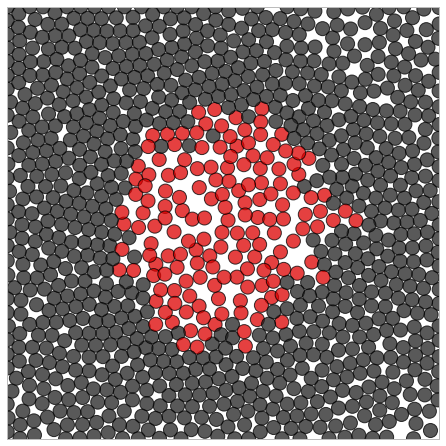

In [20]:
sim = moshpit.Moshpit(N=1024, phi=0.85)
sim.init_circle()
sim.relax()
plt = display.DisplayDiscs(sim)

# Python -- all-all forces

In [21]:
def force1(sim):
    N = sim.N
    pos = sim.pos
    dia = 2*sim.radius

    f = np.zeros_like(pos)
    for i in xrange(N):
        for j in xrange(N):
            if i != j:
                rij = pos[i] - pos[j]
                dist = np.sqrt((rij**2).sum())

                if dist < dia:
                    f[i] += sim.epsilon*(1-dist/dia)**2 * rij/dist

    return f

# numpy 1 -- all-all forces

In [22]:
def force2(sim):
    N = sim.N
    pos = sim.pos
    dia = 2*sim.radius

    rij = pos[:,None,:] - pos[None,:,:]
    dist = np.sqrt((rij**2).sum(axis=-1))

    dist[np.eye(sim.N)==1.] = 1e3
    dist = dist[:,:,None]
    forces = (sim.epsilon*(1-dist/dia)**2 * rij/dist * (dist < dia)).sum(axis=1)

    return forces

# numpy 2 -- all-all forces

In [23]:
def force3(sim):
    N = sim.N
    pos = sim.pos
    dia = 2*sim.radius

    f = np.zeros_like(pos)
    for i in xrange(N):
        rij = pos[i] - pos
        dist = np.sqrt((rij**2).sum(axis=-1))

        mask = (dist > 0)&(dist < dia)
        rij = rij[mask]
        dist = dist[mask][:,None]

        if len(rij) > 0:
            forces = sim.epsilon*(1-dist/dia)**2 * rij/dist
            f[i] += forces.sum(axis=0)

    return f

# numba jit -- all-all forces

In [24]:
@jit(nopython=True)
def _inner_naive(pos, N, eps, f):
    for i in xrange(N):
        for j in xrange(N):
            if i != j:
                x = pos[i,0] - pos[j,0]
                y = pos[i,1] - pos[j,1]
                dist = sqrt(x*x + y*y)

                if dist < 2.0:
                    c = eps*(1-dist/2.0)**2
                    f[i][0] += c * x/dist
                    f[i][1] += c * y/dist
    return f

def force4(sim):
    force = np.zeros_like(sim.pos)
    return _inner_naive(sim.pos, sim.N, sim.epsilon, force)

# numba jit -- neighbor lists

In [25]:
@jit(nopython=True)
def _nbl_forces(cells, counts, nside, box, pos, N, eps, f):
    for i in xrange(N):
        ix = int((pos[i,0] / box[0]) * nside)
        iy = int((pos[i,1] / box[1]) * nside)

        p = counts[ix,iy]
        cells[ix,iy,p] = i
        counts[ix,iy] += 1

    for i in xrange(N):
        ix = int((pos[i,0] / box[0]) * nside)
        iy = int((pos[i,1] / box[1]) * nside)

        for tx in xrange(max(0,ix-1), min(ix+2, nside)):
            for ty in xrange(max(0,iy-1), min(iy+2, nside)):
                for p in xrange(counts[tx,ty]):
                    if p > i:
                        ind = cells[tx,ty,p]
                        x = pos[i,0] - pos[ind,0]
                        y = pos[i,1] - pos[ind,1]
                        distsq = x*x + y*y

                        if distsq < 4.0:
                            dist = sqrt(distsq)
                            c = eps*(1-dist/2.0)**2 / dist
                            f[i][0] += c * x
                            f[i][1] += c * y
                            f[ind][0] -= c * x
                            f[ind][1] -= c * y
    return f

def force5(sim):
    force = np.zeros_like(sim.pos)
    nside = int(sim.box[0]/(sim.radius*2.05))
    nside = nside if nside > 0 else 1

    cells = np.zeros((nside, nside, 10), dtype='int64')
    counts = np.zeros((nside, nside), dtype='int64')

    return _nbl_forces(cells, counts, nside, sim.box, sim.pos, sim.N, sim.epsilon, force)

In [26]:
forces.warmup(sim)
%timeit forces.force1(sim)
%timeit forces.force2(sim)
%timeit forces.force3(sim)
%timeit forces.force4(sim)
%timeit forces.force5(sim)

1 loops, best of 3: 7.37 s per loop
10 loops, best of 3: 83.5 ms per loop
10 loops, best of 3: 64.3 ms per loop
100 loops, best of 3: 4.29 ms per loop
10000 loops, best of 3: 148 µs per loop


| Implementation | Speed factor |
|----------------|--------------|
| Python all-all | 1 |
| numpy all-all 1 | 80 |
| numpy all-all 2 | 100 |
| jit all-all |  1600 | 
| jit cell-based | 75,000 |

# Big-O Scaling

Since every particle only interacts with the touching neighbors, we only really need to calculate those forces.  FOr these densities, the amount of interactions is roughly $NM$ where is $N$ is the number of particles and $M$ the number of nearest neighbors.  For $N=1024$, $M=4$, we would expect $\sim1024 \times 4\times 50 = 200k$ operations, or roughly 20 microseconds.  Using the cell neighborlist, we achieve 100 microseconds, using more computing to make the list which we didn't account for.

That's not the entire story though.  Since we always locate neighboring particles in constant time, this method *scales* better than the all-all computational approach.  The all-all force calculation takes $O(N^2)$ operations while neighbor list is only $O(N)$. Let's verify this by looking at performance as a function of particle number.

In [27]:
def timer(func, args, reps=5):
    times = []

    for rep in xrange(reps):
        start = time.time()
        func(*args)
        end = time.time()
        times.append(end - start)

    return np.array(times).mean()

In [28]:
nlist = np.logspace(1, 4, 15).astype('int')
times = []

for n in nlist:
    sim = moshpit.Moshpit(N=n, phi=0.85)
    sim.relax()
    time4 = timer(forces.force4, args=(sim,), reps=20)
    time5 = timer(forces.force5, args=(sim,), reps=20)
    times.append((time4, time5))

times = np.array(times)

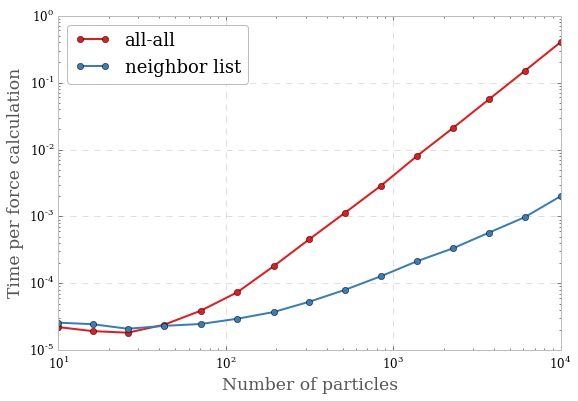

In [29]:
fig = pl.figure(figsize=(9,6))
pl.loglog(nlist, times[:,0], 'o-', label=r"all-all");
pl.loglog(nlist, times[:,1], 'o-', label=r"neighbor list");
pl.ylabel("Time per force calculation")
pl.xlabel("Number of particles")
pl.legend(loc='best', fontsize=18);

III. Hardware optimizations
============

Beyond knowing your language and algorithms, being able to speed up code also relies on knowing your architecture (type of CPU, memory access patterns, networking protocols, etc).  Let's visit a few performance concerns that are present on modern day CPUs.

### Cache sizes

Modern CPUs are very complex. For starters, there are many layers of memory which have different speeds: L1, L2, L3 (on CPU), and DRAM (the big one listed on newegg).

In [30]:
nums = (2**np.linspace(10, 23, 13*5+1)).astype('int')
times = []

for n in nums:
    a = np.random.rand(n)
    times.append(timer(np.dot, reps=10000, args=(a,a)))

times = np.array(times)

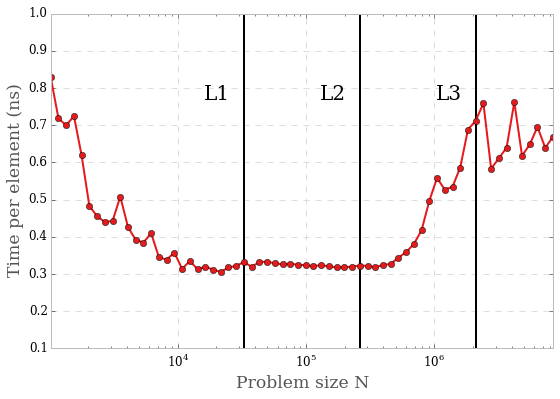

In [31]:
l1, l2, l3 = 2**17, 2**20, 2**23
y0,y1 = (1e-1, 1e0)

fig = pl.figure(figsize=(9,6))
pl.semilogx(nums, times/nums/1e-9, 'o-');

for l,n in zip([l1, l2, l3], ['L1', 'L2', 'L3']):
    pl.vlines(l/4, y0, y1)
    pl.text(l/8, y1/1.3, n, fontsize=20)

pl.xlabel("Problem size N")
pl.ylabel("Time per element (ns)")
pl.ylim(y0, y1)
pl.xlim(nums[0], nums[-1]);

### Cache hits

Reading from any type of memory (caches, DRAM, hard disk) happens in chunks.  Since reading memory can be slow, utilizing these chunks is important

In [32]:
from numba import jit

@jit(nopython=True)
def cache_hit(a, N):
    out = 0
    for i in xrange(N):
        for j in xrange(N):
            out += a[i*N+j]
    return out

@jit(nopython=True)
def cache_miss(a, N):
    out = 0
    for i in xrange(N):
        for j in xrange(N):
            out += a[i+j*N]
    return out

N = int(1e3)
a = np.random.rand(N,N)
a = ((a + a.T)/2).flatten()

out0, out1 = cache_hit(a,N), cache_miss(a,N)
print out0 == out1

%timeit cache_hit(a, N)
%timeit cache_miss(a, N)

True
1000 loops, best of 3: 913 µs per loop
100 loops, best of 3: 7.3 ms per loop


### Branch prediction

A CPU does not just execute the instructions which you ask of it.  It has computational pipelines which decide what memory to load when and predict what needs to be run next.  If there are branches (if, for, etc) then it tries to streamline the process by building models of what will happen next

In [33]:
N = int(1e6)
a = np.random.rand(N)
b = a.copy()
b.sort()

@jit(nopython=True)
def sum_threshold(t, N, threshold):
    out = 0
    for i in xrange(N):
        if t[i] > threshold:
            out += t[i]
    return out

print np.allclose(sum_threshold(a, N, 0.5), sum_threshold(b, N, 0.5))

%timeit sum_threshold(a, N, 0.5)
%timeit sum_threshold(b, N, 0.5)

True
100 loops, best of 3: 4.42 ms per loop
1000 loops, best of 3: 1.04 ms per loop


In [34]:
threshold = np.linspace(0, 1, 100)
times = []

N = int(1e5)
a = np.random.rand(N)
b = a.copy()
b.sort()

for thresh in threshold:
    t0 = timer(sum_threshold, reps=200, args=(a,N,thresh))
    t1 = timer(sum_threshold, reps=200, args=(b,N,thresh))
    times.append((t0, t1))        

times = np.array(times)

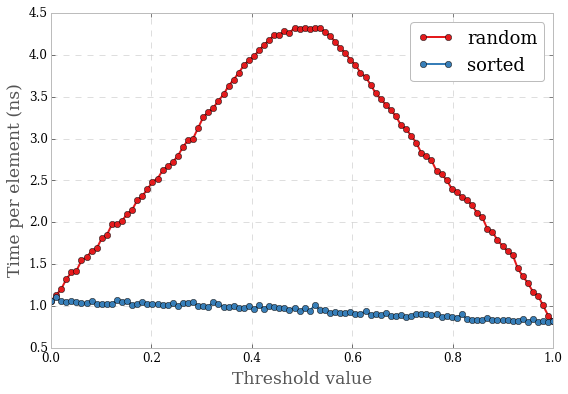

In [35]:
pl.figure(figsize=(9,6))
pl.plot(threshold, times[:,0]/1e-9/N, 'o-', label='random')
pl.plot(threshold, times[:,1]/1e-9/N, 'o-', label='sorted')
pl.xlabel("Threshold value")
pl.ylabel("Time per element (ns)")
pl.legend(loc='best', fontsize=18);

## GPUs

One of the popular methods to speed up code is to translate the method into GPU code via CUDA or OpenCL (or OpenGL GLSL), two languages that allow you to specify computation on GPUs.  Python offers several ways to use GPUs

* **numbapro** -- similar to numba jit but can be easily extended to GPUs
* **pycuda** / **pyopencl** -- direct interfaces to both popular GPU languages
* **theano** -- GPUs for machine learning in Python

While GPUs have very fast memory bandwidth and many parallel processes, they require expertise to properly utilize the different types of memory and the massive parallelism.  For simple problems, GPUs force you to write much better code than even raw C so that many people see a speed up of ~20-100x.  However, by raw numbers, GPUs aren't that much better: top CPUs clock in at ~500 GFLOPS and top GPUs at ~4000 GLOPS, a factor of 8x.  While a large factor, that means if both codes are written optimally on both platforms, that is the best to expect.  

In practice, utilizing either properly is very difficult, so it is very problem specific as to what gains you will see.